In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sb
from collections import Counter
import warnings
warnings.filterwarnings("ignore")

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier,VotingClassifier
from sklearn.naive_bayes import GaussianNB,MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import BernoulliNB
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder,normalize,MinMaxScaler
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.metrics import confusion_matrix,roc_auc_score,roc_curve
import seaborn as sns

In [2]:
import tensorflow as tf

# GPU device Check.
device_name = tf.test.gpu_device_name()
if device_name == '/device:GPU:0':
    print('Found GPU at: {}'.format(device_name))
else:
    raise SystemError('GPU device not found')

Found GPU at: /device:GPU:0


In [3]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():    

    # PyTorch use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla P100-PCIE-16GB


Read data

In [4]:
# Reading data
train = pd.read_csv('../input/higgs-boson/training.zip')
test = pd.read_csv('../input/higgs-boson/test.zip')

In [5]:
train.head()

,EventId,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_tau_lep,DER_pt_tot,...,PRI_jet_num,PRI_jet_leading_pt,PRI_jet_leading_eta,PRI_jet_leading_phi,PRI_jet_subleading_pt,PRI_jet_subleading_eta,PRI_jet_subleading_phi,PRI_jet_all_pt,Weight,Label
0,100000,138.470,51.655,97.827,27.980,0.91,124.711,2.666,3.064,41.928,...,2,67.435,2.150,0.444,46.062,1.24,-2.475,113.497,0.002653,s
1,100001,160.937,68.768,103.235,48.146,-999.00,-999.000,-999.000,3.473,2.078,...,1,46.226,0.725,1.158,-999.000,-999.00,-999.000,46.226,2.233584,b
2,100002,-999.000,162.172,125.953,35.635,-999.00,-999.000,-999.000,3.148,9.336,...,1,44.251,2.053,-2.028,-999.000,-999.00,-999.000,44.251,2.347389,b
3,100003,143.905,81.417,80.943,0.414,-999.00,-999.000,-999.000,3.310,0.414,...,0,-999.000,-999.000,-999.000,-999.000,-999.00,-999.000,-0.000,5.446378,b
4,100004,175.864,16.915,134.805,16.405,-999.00,-999.000,-999.000,3.891,16.405,...,0,-999.000,-999.000,-999.000,-999.000,-999.00,-999.000,0.000,6.245333,b


In [6]:
test.head()

,EventId,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_tau_lep,DER_pt_tot,...,PRI_met_phi,PRI_met_sumet,PRI_jet_num,PRI_jet_leading_pt,PRI_jet_leading_eta,PRI_jet_leading_phi,PRI_jet_subleading_pt,PRI_jet_subleading_eta,PRI_jet_subleading_phi,PRI_jet_all_pt
0,350000,-999.000,79.589,23.916,3.036,-999.000,-999.000,-999.000,0.903,3.036,...,2.022,98.556,0,-999.000,-999.000,-999.000,-999.000,-999.000,-999.000,-0.000
1,350001,106.398,67.490,87.949,49.994,-999.000,-999.000,-999.000,2.048,2.679,...,-1.138,176.251,1,47.575,-0.553,-0.849,-999.000,-999.000,-999.000,47.575
2,350002,117.794,56.226,96.358,4.137,-999.000,-999.000,-999.000,2.755,4.137,...,-1.868,111.505,0,-999.000,-999.000,-999.000,-999.000,-999.000,-999.000,0.000
3,350003,135.861,30.604,97.288,9.104,-999.000,-999.000,-999.000,2.811,9.104,...,1.172,164.707,0,-999.000,-999.000,-999.000,-999.000,-999.000,-999.000,0.000
4,350004,74.159,82.772,58.731,89.646,1.347,536.663,-0.339,1.028,77.213,...,-0.231,869.614,3,254.085,-1.013,-0.334,185.857,0.335,2.587,599.213


train shape: 100 rows × 33 columns

test shape: 5 rows × 31 columns

In [7]:
print(train.columns.values,'\n')
print(test.columns.values)

['EventId' 'DER_mass_MMC' 'DER_mass_transverse_met_lep' 'DER_mass_vis'
 'DER_pt_h' 'DER_deltaeta_jet_jet' 'DER_mass_jet_jet'
 'DER_prodeta_jet_jet' 'DER_deltar_tau_lep' 'DER_pt_tot' 'DER_sum_pt'
 'DER_pt_ratio_lep_tau' 'DER_met_phi_centrality' 'DER_lep_eta_centrality'
 'PRI_tau_pt' 'PRI_tau_eta' 'PRI_tau_phi' 'PRI_lep_pt' 'PRI_lep_eta'
 'PRI_lep_phi' 'PRI_met' 'PRI_met_phi' 'PRI_met_sumet' 'PRI_jet_num'
 'PRI_jet_leading_pt' 'PRI_jet_leading_eta' 'PRI_jet_leading_phi'
 'PRI_jet_subleading_pt' 'PRI_jet_subleading_eta' 'PRI_jet_subleading_phi'
 'PRI_jet_all_pt' 'Weight' 'Label'] 

['EventId' 'DER_mass_MMC' 'DER_mass_transverse_met_lep' 'DER_mass_vis'
 'DER_pt_h' 'DER_deltaeta_jet_jet' 'DER_mass_jet_jet'
 'DER_prodeta_jet_jet' 'DER_deltar_tau_lep' 'DER_pt_tot' 'DER_sum_pt'
 'DER_pt_ratio_lep_tau' 'DER_met_phi_centrality' 'DER_lep_eta_centrality'
 'PRI_tau_pt' 'PRI_tau_eta' 'PRI_tau_phi' 'PRI_lep_pt' 'PRI_lep_eta'
 'PRI_lep_phi' 'PRI_met' 'PRI_met_phi' 'PRI_met_sumet' 'PRI_jet_num'
 'PRI_j

In [8]:
train = train.drop(['Weight'], axis=1)

b    164333
s     85667
Name: Label, dtype: int64


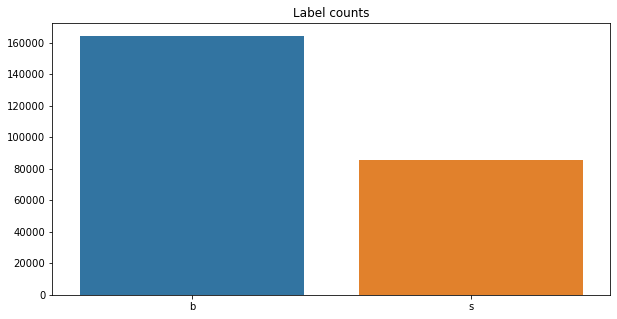

In [9]:
print(train['Label'].value_counts())

rcParams['figure.figsize'] = 10,5
sb.barplot(x = train['Label'].value_counts().index, y = train['Label'].value_counts().values)
plt.title('Label counts')
plt.show()

Data Preparation

In [10]:
# getting dummy variables column

enc = LabelEncoder()

train['Label'] = enc.fit_transform(train['Label'])
train.head()

,EventId,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_tau_lep,DER_pt_tot,...,PRI_met_sumet,PRI_jet_num,PRI_jet_leading_pt,PRI_jet_leading_eta,PRI_jet_leading_phi,PRI_jet_subleading_pt,PRI_jet_subleading_eta,PRI_jet_subleading_phi,PRI_jet_all_pt,Label
0,100000,138.470,51.655,97.827,27.980,0.91,124.711,2.666,3.064,41.928,...,258.733,2,67.435,2.150,0.444,46.062,1.24,-2.475,113.497,1
1,100001,160.937,68.768,103.235,48.146,-999.00,-999.000,-999.000,3.473,2.078,...,164.546,1,46.226,0.725,1.158,-999.000,-999.00,-999.000,46.226,0
2,100002,-999.000,162.172,125.953,35.635,-999.00,-999.000,-999.000,3.148,9.336,...,260.414,1,44.251,2.053,-2.028,-999.000,-999.00,-999.000,44.251,0
3,100003,143.905,81.417,80.943,0.414,-999.00,-999.000,-999.000,3.310,0.414,...,86.062,0,-999.000,-999.000,-999.000,-999.000,-999.00,-999.000,-0.000,0
4,100004,175.864,16.915,134.805,16.405,-999.00,-999.000,-999.000,3.891,16.405,...,53.131,0,-999.000,-999.000,-999.000,-999.000,-999.00,-999.000,0.000,0


In [11]:
y = train["Label"]
X = train
X_test = test

In [12]:
X.set_index(['EventId'],inplace = True)
X_test.set_index(['EventId'],inplace = True)
X = X.drop(['Label'], axis=1)

X.head()

,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_tau_lep,DER_pt_tot,DER_sum_pt,...,PRI_met_phi,PRI_met_sumet,PRI_jet_num,PRI_jet_leading_pt,PRI_jet_leading_eta,PRI_jet_leading_phi,PRI_jet_subleading_pt,PRI_jet_subleading_eta,PRI_jet_subleading_phi,PRI_jet_all_pt
EventId,,,,,,,,,,,,,,,,,,,,,
100000,138.470,51.655,97.827,27.980,0.91,124.711,2.666,3.064,41.928,197.760,...,-0.277,258.733,2,67.435,2.150,0.444,46.062,1.24,-2.475,113.497
100001,160.937,68.768,103.235,48.146,-999.00,-999.000,-999.000,3.473,2.078,125.157,...,-1.916,164.546,1,46.226,0.725,1.158,-999.000,-999.00,-999.000,46.226
100002,-999.000,162.172,125.953,35.635,-999.00,-999.000,-999.000,3.148,9.336,197.814,...,-2.186,260.414,1,44.251,2.053,-2.028,-999.000,-999.00,-999.000,44.251
100003,143.905,81.417,80.943,0.414,-999.00,-999.000,-999.000,3.310,0.414,75.968,...,0.060,86.062,0,-999.000,-999.000,-999.000,-999.000,-999.00,-999.000,-0.000
100004,175.864,16.915,134.805,16.405,-999.00,-999.000,-999.000,3.891,16.405,57.983,...,-0.871,53.131,0,-999.000,-999.000,-999.000,-999.000,-999.00,-999.000,0.000


In [13]:
X_test.head()

,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_tau_lep,DER_pt_tot,DER_sum_pt,...,PRI_met_phi,PRI_met_sumet,PRI_jet_num,PRI_jet_leading_pt,PRI_jet_leading_eta,PRI_jet_leading_phi,PRI_jet_subleading_pt,PRI_jet_subleading_eta,PRI_jet_subleading_phi,PRI_jet_all_pt
EventId,,,,,,,,,,,,,,,,,,,,,
350000,-999.000,79.589,23.916,3.036,-999.000,-999.000,-999.000,0.903,3.036,56.018,...,2.022,98.556,0,-999.000,-999.000,-999.000,-999.000,-999.000,-999.000,-0.000
350001,106.398,67.490,87.949,49.994,-999.000,-999.000,-999.000,2.048,2.679,132.865,...,-1.138,176.251,1,47.575,-0.553,-0.849,-999.000,-999.000,-999.000,47.575
350002,117.794,56.226,96.358,4.137,-999.000,-999.000,-999.000,2.755,4.137,97.600,...,-1.868,111.505,0,-999.000,-999.000,-999.000,-999.000,-999.000,-999.000,0.000
350003,135.861,30.604,97.288,9.104,-999.000,-999.000,-999.000,2.811,9.104,94.112,...,1.172,164.707,0,-999.000,-999.000,-999.000,-999.000,-999.000,-999.000,0.000
350004,74.159,82.772,58.731,89.646,1.347,536.663,-0.339,1.028,77.213,721.552,...,-0.231,869.614,3,254.085,-1.013,-0.334,185.857,0.335,2.587,599.213


In [14]:
train.describe()

,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_tau_lep,DER_pt_tot,DER_sum_pt,...,PRI_met_sumet,PRI_jet_num,PRI_jet_leading_pt,PRI_jet_leading_eta,PRI_jet_leading_phi,PRI_jet_subleading_pt,PRI_jet_subleading_eta,PRI_jet_subleading_phi,PRI_jet_all_pt,Label
count,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,...,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000
mean,-49.023079,49.239819,81.181982,57.895962,-708.420675,-601.237051,-709.356603,2.373100,18.917332,158.432217,...,209.797178,0.979176,-348.329567,-399.254314,-399.259788,-692.381204,-709.121609,-709.118631,73.064591,0.342668
std,406.345647,35.344886,40.828691,63.655682,454.480565,657.972302,453.019877,0.782911,22.273494,115.706115,...,126.499506,0.977426,532.962789,489.338286,489.333883,479.875496,453.384624,453.389017,98.015662,0.474603
min,-999.000000,0.000000,6.329000,0.000000,-999.000000,-999.000000,-999.000000,0.208000,0.000000,46.104000,...,13.678000,0.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,0.000000,0.000000
25%,78.100750,19.241000,59.388750,14.068750,-999.000000,-999.000000,-999.000000,1.810000,2.841000,77.550000,...,123.017500,0.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,0.000000,0.000000
50%,105.012000,46.524000,73.752000,38.467500,-999.000000,-999.000000,-999.000000,2.491500,12.315500,120.664500,...,179.739000,1.000000,38.960000,-1.872000,-2.093000,-999.000000,-999.000000,-999.000000,40.512500,0.000000
75%,130.606250,73.598000,92.259000,79.169000,0.490000,83.446000,-4.593000,2.961000,27.591000,200.478250,...,263.379250,2.000000,75.349000,0.433000,0.503000,33.703000,-2.457000,-2.275000,109.933750,1.000000
max,1192.026000,690.075000,1349.351000,2834.999000,8.503000,4974.979000,16.690000,5.684000,2834.999000,1852.462000,...,2003.976000,3.000000,1120.573000,4.499000,3.141000,721.456000,4.500000,3.142000,1633.433000,1.000000


In [15]:
# #Normalizing

# no = 1

# X["PRI_jet_all_pt"]=((X["PRI_jet_all_pt"]-X["PRI_jet_all_pt"].min())/(X["PRI_jet_all_pt"].max()-X["PRI_jet_all_pt"].min()))*no
# X_test["PRI_jet_all_pt"]=((X_test["PRI_jet_all_pt"]-X_test["PRI_jet_all_pt"].min())/(X_test["PRI_jet_all_pt"].max()-X_test["DER_mass_MMC"].min()))*no

# X["PRI_jet_subleading_pt"]=((X["PRI_jet_subleading_pt"]-X["PRI_jet_subleading_pt"].min())/(X["PRI_jet_subleading_pt"].max()-X["PRI_jet_subleading_pt"].min()))*no
# X_test["PRI_jet_subleading_pt"]=((X_test["PRI_jet_subleading_pt"]-X_test["PRI_jet_subleading_pt"].min())/(X_test["PRI_jet_subleading_pt"].max()-X_test["PRI_jet_subleading_pt"].min()))*no

# X["PRI_jet_leading_pt"]=((X["PRI_jet_leading_pt"]-X["PRI_jet_leading_pt"].min())/(X["PRI_jet_leading_pt"].max()-X["PRI_jet_leading_pt"].min()))*no
# X_test["PRI_jet_leading_pt"]=((X_test["PRI_jet_leading_pt"]-X_test["PRI_jet_leading_pt"].min())/(X_test["PRI_jet_leading_pt"].max()-X_test["PRI_jet_leading_pt"].min()))*no

# X["PRI_met_sumet"]=((X["PRI_met_sumet"]-X["PRI_met_sumet"].min())/(X["PRI_met_sumet"].max()-X["PRI_met_sumet"].min()))*no
# X_test["PRI_met_sumet"]=((X_test["PRI_met_sumet"]-X_test["PRI_met_sumet"].min())/(X_test["PRI_met_sumet"].max()-X_test["PRI_met_sumet"].min()))*no

# X["DER_sum_pt"]=((X["DER_sum_pt"]-X["DER_sum_pt"].min())/(X["DER_sum_pt"].max()-X["DER_sum_pt"].min()))*no
# X_test["DER_sum_pt"]=((X_test["DER_sum_pt"]-X_test["DER_sum_pt"].min())/(X_test["DER_sum_pt"].max()-X_test["DER_sum_pt"].min()))*no

# X["DER_mass_jet_jet"]=((X["DER_mass_jet_jet"]-X["DER_mass_jet_jet"].min())/(X["DER_mass_jet_jet"].max()-X["DER_mass_jet_jet"].min()))*no
# X_test["DER_mass_jet_jet"]=((X_test["DER_mass_jet_jet"]-X_test["DER_mass_jet_jet"].min())/(X_test["DER_mass_jet_jet"].max()-X_test["DER_mass_jet_jet"].min()))*no

# X["DER_pt_h"]=((X["DER_pt_h"]-X["DER_pt_h"].min())/(X["DER_pt_h"].max()-X["DER_pt_h"].min()))*no
# X_test["DER_pt_h"]=((X_test["DER_pt_h"]-X_test["DER_pt_h"].min())/(X_test["DER_pt_h"].max()-X_test["DER_pt_h"].min()))*no

# X["DER_mass_vis"]=((X["DER_mass_vis"]-X["DER_mass_vis"].min())/(X["DER_mass_vis"].max()-X["DER_mass_vis"].min()))*no
# X_test["DER_mass_vis"]=((X_test["DER_mass_vis"]-X_test["DER_mass_vis"].min())/(X_test["DER_mass_vis"].max()-X_test["DER_mass_vis"].min()))*no

# X["DER_mass_transverse_met_lep"]=((X["DER_mass_transverse_met_lep"]-X["DER_mass_transverse_met_lep"].min())/(X["DER_mass_transverse_met_lep"].max()-X["DER_mass_transverse_met_lep"].min()))*no
# X_test["DER_mass_transverse_met_lep"]=((X_test["DER_mass_transverse_met_lep"]-X_test["DER_mass_transverse_met_lep"].min())/(X_test["DER_mass_transverse_met_lep"].max()-X_test["DER_mass_transverse_met_lep"].min()))*no

# X["DER_mass_MMC"]=((X["DER_mass_MMC"]-X["DER_mass_MMC"].min())/(X["DER_mass_MMC"].max()-X["DER_mass_MMC"].min()))*no
# X_test["DER_mass_MMC"]=((X_test["DER_mass_MMC"]-X_test["DER_mass_MMC"].min())/(X_test["DER_mass_MMC"].max()-X_test["DER_mass_MMC"].min()))*no


# X.head()

In [16]:
# # normalize the data attributes
# X = X.apply(lambda x: (x - np.mean(x)) / (np.max(x) - np.min(x)))

# X_test = X_test.apply(lambda x: (x - np.mean(x)) / (np.max(x) - np.min(x)))


# X.head()

In [17]:
#Normalizing

from sklearn.preprocessing import normalize

X = normalize(X)
X_test = normalize(X_test)

In [18]:
# print(X.isnull().sum(),'\n')
# print(X_test.isnull().sum())

In [19]:
#X = X.replace(-999.000,np.nan)
#X.head()

In [20]:
#X_test = X_test.replace(-999.000,np.nan)

In [21]:
#X_test.head()

In [22]:
#X = X.replace(-999.000,0)
#X_test = X_test.replace(-999.000,0)
#X.head()

In [23]:
#print(X.isnull().sum(),'\n')
#print(X_test.isnull().sum())

In [24]:
#X.fillna(X.median(), inplace=True)
#X_test.fillna(X_test.median(), inplace=True)

#X.head()

In [25]:
#X.tail(1000)

In [26]:
X_train,X_test,y_train,y_test = train_test_split(X,y,random_state = 10,test_size=0.2,shuffle =True)

1- Logistic Regression Model

In [27]:
logistic_regression= LogisticRegression()
logistic_regression.fit(X_train,y_train)
y_pred=logistic_regression.predict(X_test)

2- Random Forest Model

In [28]:
# fit the model on the whole dataset
random_forest = RandomForestClassifier()

random_forest.fit(X_train, y_train)

RandomForestClassifier()

3- Decision Tree Model

In [29]:
decisionTreeModel = DecisionTreeClassifier(criterion= 'entropy',
                                           max_depth = None, 
                                           splitter='best', 
                                           random_state=10)

decisionTreeModel.fit(X_train,y_train)

DecisionTreeClassifier(criterion='entropy', random_state=10)

4- Gradient Boosting Model

In [ ]:
# gradientBoostingModel = GradientBoostingClassifier(loss = 'deviance',
#                                                    learning_rate = 0.01,
#                                                    n_estimators = 100,
#                                                    max_depth = 30,
#                                                    random_state=10)

# gradientBoostingModel.fit(X_train,y_train)

5- Nearest Neighbors Model

In [30]:
KNeighborsModel = KNeighborsClassifier(n_neighbors = 7,
                                       weights = 'distance',
                                      algorithm = 'brute')

KNeighborsModel.fit(X_train,y_train)

KNeighborsClassifier(algorithm='brute', n_neighbors=7, weights='distance')

6- Stochastic Gradient Descent Model

In [ ]:
# SGDClassifier = SGDClassifier(loss = 'hinge', 
#                               penalty = 'l1',
#                               learning_rate = 'optimal',
#                               random_state = 10, 
#                               max_iter=100)

# SGDClassifier.fit(X_train,y_train)

7- Support Vector Machine Model

In [ ]:
# SVClassifier = SVC(kernel= 'linear',
#                    degree=3,
#                    max_iter=10000,
#                    C=2, 
#                    random_state = 55)

# SVClassifier.fit(X_train,y_train)

8- Bernoulli Naive Bayes Model

In [31]:
bernoulliNBModel = BernoulliNB(alpha=0.1)
bernoulliNBModel.fit(X_train,y_train)

BernoulliNB(alpha=0.1)

9- Gaussian Naive Bayes Model

In [32]:
gaussianNBModel = GaussianNB()
gaussianNBModel.fit(X_train,y_train)

GaussianNB()

10- XGBoost Model

In [33]:
XGB_Classifier = XGBClassifier()
XGB_Classifier.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

**Models evaluation**

In [34]:
#evaluation Details
models = [logistic_regression, random_forest, decisionTreeModel, KNeighborsModel, 
            bernoulliNBModel, gaussianNBModel, XGB_Classifier]

for model in models:
    print(type(model).__name__,' Train Score is   : ' ,model.score(X_train, y_train))
    print(type(model).__name__,' Test Score is    : ' ,model.score(X_test, y_test))
    
    y_pred = model.predict(X_test)
    print(type(model).__name__,' F1 Score is      : ' ,f1_score(y_test,y_pred))
    print('--------------------------------------------------------------------------')

LogisticRegression  Train Score is   :  0.703645
LogisticRegression  Test Score is    :  0.70304
LogisticRegression  F1 Score is      :  0.3758722152164775
--------------------------------------------------------------------------
RandomForestClassifier  Train Score is   :  0.999995
RandomForestClassifier  Test Score is    :  0.82484
RandomForestClassifier  F1 Score is      :  0.7251616142597125
--------------------------------------------------------------------------
DecisionTreeClassifier  Train Score is   :  1.0
DecisionTreeClassifier  Test Score is    :  0.75264
DecisionTreeClassifier  F1 Score is      :  0.6409869375907111
--------------------------------------------------------------------------
KNeighborsClassifier  Train Score is   :  1.0
KNeighborsClassifier  Test Score is    :  0.78606
KNeighborsClassifier  F1 Score is      :  0.6794330066828493
--------------------------------------------------------------------------
BernoulliNB  Train Score is   :  0.62541
BernoulliNB  Te

I will use XGBClassifier Model

Prediction

In [36]:
y_pred = XGB_Classifier.predict(X_test)

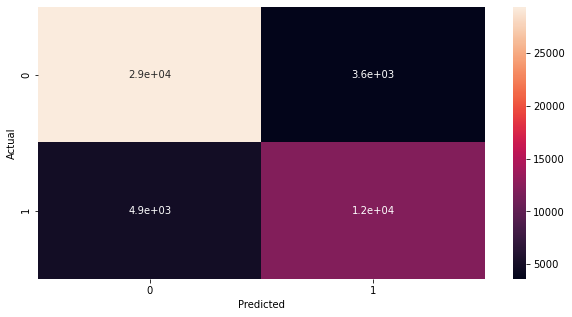

In [37]:
import seaborn as sn

confusion_matrix = pd.crosstab(y_test, y_pred, rownames=['Actual'], colnames=['Predicted'])
sn.heatmap(confusion_matrix, annot=True)

In [38]:
from sklearn.metrics import accuracy_score,classification_report

print(accuracy_score(y_test,y_pred).round(4)*100,'\n')

print(pd.crosstab(y_test,y_pred),'\n')

print(classification_report(y_test,y_pred),'\n')

82.89 

col_0      0      1
Label              
0      29345   3626
1       4931  12098 

              precision    recall  f1-score   support

           0       0.86      0.89      0.87     32971
           1       0.77      0.71      0.74     17029

    accuracy                           0.83     50000
   macro avg       0.81      0.80      0.81     50000
weighted avg       0.83      0.83      0.83     50000
 



In [39]:
X_test.shape

(50000, 30)

In [40]:
test.shape

(550000, 30)

In [41]:
test_to_pred = normalize(test)

In [42]:
test_predict = XGB_Classifier.predict(test_to_pred)

In [43]:
test.reset_index(inplace = True)
test.head()

,EventId,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_tau_lep,DER_pt_tot,...,PRI_met_phi,PRI_met_sumet,PRI_jet_num,PRI_jet_leading_pt,PRI_jet_leading_eta,PRI_jet_leading_phi,PRI_jet_subleading_pt,PRI_jet_subleading_eta,PRI_jet_subleading_phi,PRI_jet_all_pt
0,350000,-999.000,79.589,23.916,3.036,-999.000,-999.000,-999.000,0.903,3.036,...,2.022,98.556,0,-999.000,-999.000,-999.000,-999.000,-999.000,-999.000,-0.000
1,350001,106.398,67.490,87.949,49.994,-999.000,-999.000,-999.000,2.048,2.679,...,-1.138,176.251,1,47.575,-0.553,-0.849,-999.000,-999.000,-999.000,47.575
2,350002,117.794,56.226,96.358,4.137,-999.000,-999.000,-999.000,2.755,4.137,...,-1.868,111.505,0,-999.000,-999.000,-999.000,-999.000,-999.000,-999.000,0.000
3,350003,135.861,30.604,97.288,9.104,-999.000,-999.000,-999.000,2.811,9.104,...,1.172,164.707,0,-999.000,-999.000,-999.000,-999.000,-999.000,-999.000,0.000
4,350004,74.159,82.772,58.731,89.646,1.347,536.663,-0.339,1.028,77.213,...,-0.231,869.614,3,254.085,-1.013,-0.334,185.857,0.335,2.587,599.213


In [44]:
predict = test['EventId']

In [46]:
test_predict = pd.Series(test_predict)

In [47]:
predict = pd.concat([predict,test_predict], axis=1)

In [48]:
predict.rename(columns={0: "Class"},inplace=True)

In [49]:
predict = predict.replace(1,'s')
predict = predict.replace(0,'b')

In [50]:
predict['RankOrder'] = predict['Class'].argsort().argsort() + 1 # +1 to start at 1

In [51]:
predict = predict[['EventId', 'RankOrder','Class']]

In [52]:
predict.to_csv("submission.csv",index=False)

In [53]:
predict.tail(200)

,EventId,RankOrder,Class
549800,899800,148590,b
549801,899801,148589,b
549802,899802,384570,s
549803,899803,384670,s
549804,899804,384734,s
...,...,...,...
549995,899995,148717,b
549996,899996,148716,b
549997,899997,148715,b
549998,899998,109656,b


In [54]:
print(predict.RankOrder.min())
print(predict.RankOrder.max())

1
550000


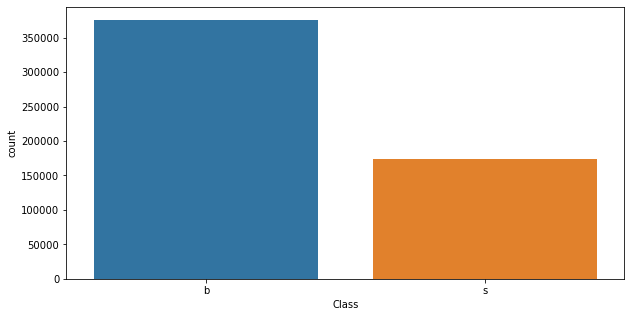

In [55]:
sb.countplot(predict.Class)